In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data=open("hello.txt").read().lower()

In [ ]:
data

'harry potter and the philosopher\'s stone is a fantasy novel written by british author j. k. rowling. the first novel in the harry potter series and rowling\'s debut novel, it follows harry potter, a young wizard who discovers his magical heritage on his eleventh birthday, when he receives a letter of acceptance to hogwarts school of witchcraft and wizardry. harry makes close friends and a few enemies during his first year at the school, and with the help of his friends, he faces an attempted comeback by the dark wizard lord voldemort, who killed harry\'s parents, but failed to kill harry when he was just 15 months old.\n\nthe book was first published in the united kingdom on 26 june 1997 by bloomsbury. it was published in the united states the following year by scholastic corporation under the title harry potter and the sorcerer\'s stone. it won most of the british book awards that were judged by children and other awards in the us. the book reached the top of the new york times list

In [ ]:
chars = set(data)
vocab_size = len(chars)
print('data has %d characters, %d unique' % (len(data), vocab_size))
char_to_idx = {w: i for i,w in enumerate(chars)}
idx_to_char = {i: w for i,w in enumerate(chars)}

data has 31841 characters, 62 unique


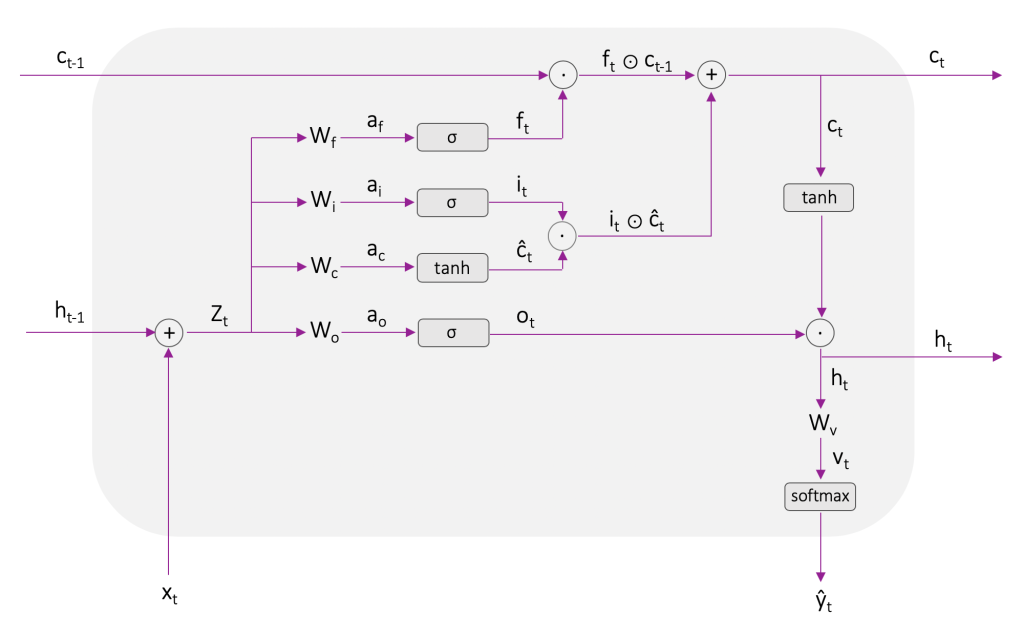

In [ ]:
class LSTM:
  def __init__(self,char_to_idx,idx_to_char,vocab_size,n_h=100,seq_len=25,epochs=10,learning_rate=0.01,beta1=0.9,beta2=0.999):
    self.char_to_idx=char_to_idx
    self.idx_to_char=idx_to_char
    self.vocab_size=vocab_size
    self.n_h=n_h
    self.seq_len=seq_len
    self.epochs=epochs
    self.learing_rate=learning_rate 
    self.beta1 = beta1 # 1st momentum parameter
    self.beta2 = beta2 # 2nd momentum parameter
    #-----initialise weights and biases-----#
    self.params = {}
    std = (1.0/np.sqrt(self.vocab_size + self.n_h)) # Xavier initialisation
    # forget gate
    self.params["Wf"] = np.random.randn(self.n_h, self.n_h + self.vocab_size) * std
    self.params["bf"] = np.ones((self.n_h,1))
    # input gate
    self.params["Wi"] = np.random.randn(self.n_h, self.n_h + self.vocab_size) * std
    self.params["bi"] = np.zeros((self.n_h,1))
    # cell gate
    self.params["Wc"] = np.random.randn(self.n_h, self.n_h + self.vocab_size) * std
    self.params["bc"] = np.zeros((self.n_h,1))
    # output gate
    self.params["Wo"] = np.random.randn(self.n_h, self.n_h + self.vocab_size) * std
    self.params["bo"] = np.zeros((self.n_h ,1))
    # output
    self.params["Wv"] = np.random.randn(self.vocab_size, self.n_h)*(1.0/np.sqrt(self.vocab_size))
    self.params["bv"] = np.zeros((self.vocab_size ,1))
    self.grads={}
    self.adam_params = {}
    for key in self.params:
      self.grads["d"+key]=np.zeros_like(self.params[key])
      self.adam_params["m"+key]=np.zeros_like(self.params[key])
      self.adam_params['"v'+key]=np.zeros_like(self.params[key])
      self.smooth_loss=-np.log(1.0/self.vocab_size)*self.seq_len
    return


In [ ]:
def sigmoid(self,x):
  return 1/(1+np.exp(-x))

LSTM.sigmoid=sigmoid

def softmax(Self,x):
  #For numerical stability
  e_x= np.exp(x-np.max(x))
  return e_x/np.sum(e_x)
LSTM.softmax=softmax


In [ ]:
def clip_grad(self):
  for key in self.grads:
    np.clip(self.grads[key],-5,5,out=self.grads[key])
  return

LSTM.clip_grads=clip_grad

In [ ]:
def reset_grads(self):
  for key in self.params:
    self.params[key].fill(0)
  return
LSTM.reset_grads=reset_grads

In [ ]:
def update_params(self, batch_num):
    for key in self.params:
        self.adam_params["m"+key] = self.adam_params["m"+key] * self.beta1 + (1 - self.beta1) * self.grads["d"+key]
        self.adam_params["v"+key] = self.adam_params["v"+key] * self.beta2 +   (1 - self.beta2) * self.grads["d"+key]**2
        m_correlated = self.adam_params["m" + key] / (1 - self.beta1**batch_num)
        v_correlated = self.adam_params["v" + key] / (1 - self.beta2**batch_num) 
        self.params[key] -= self.lr * m_correlated / (np.sqrt(v_correlated) + 1e-8) 
    return
LSTM.update_params = update_params

In [ ]:
def backward_step(self, y, y_hat, dh_next, dc_next, c_prev, z, f, i, c_bar, c, o, h):
    dv = np.copy(y_hat)
    dv[y] -= 1 # yhat - y

    self.grads["dWv"] += np.dot(dv, h.T)
    self.grads["dbv"] += dv

    dh = np.dot(self.params["Wv"].T, dv)
    dh += dh_next
    
    do = dh * np.tanh(c)
    da_o = do * o*(1-o)
    self.grads["dWo"] += np.dot(da_o, z.T)
    self.grads["dbo"] += da_o

    dc = dh * o * (1-np.tanh(c)**2)
    dc += dc_next

    dc_bar = dc * i
    da_c = dc_bar * (1-c_bar**2)
    self.grads["dWc"] += np.dot(da_c, z.T)
    self.grads["dbc"] += da_c

    di = dc * c_bar
    da_i = di * i*(1-i) 
    self.grads["dWi"] += np.dot(da_i, z.T)
    self.grads["dbi"] += da_i

    df = dc * c_prev
    da_f = df * f*(1-f)
    self.grads["dWf"] += np.dot(da_f, z.T)
    self.grads["dbf"] += da_f

    dz = (np.dot(self.params["Wf"].T, da_f)
         + np.dot(self.params["Wi"].T, da_i)
         + np.dot(self.params["Wc"].T, da_c)
         + np.dot(self.params["Wo"].T, da_o))

    dh_prev = dz[:self.n_h, :]
    dc_prev = f * dc
    return dh_prev, dc_prev

LSTM.backward_step = backward_step

In [ ]:
def forward_step(self, x, h_prev, c_prev):
    z = np.row_stack((h_prev, x))

    f = self.sigmoid(np.dot(self.params["Wf"], z) + self.params["bf"])
    i = self.sigmoid(np.dot(self.params["Wi"], z) + self.params["bi"])
    c_bar = np.tanh(np.dot(self.params["Wc"], z) + self.params["bc"])

    c = f * c_prev + i * c_bar
    o = self.sigmoid(np.dot(self.params["Wo"], z) + self.params["bo"])
    h = o * np.tanh(c)

    v = np.dot(self.params["Wv"], h) + self.params["bv"]
    y_hat = self.softmax(v)
    return y_hat, v, h, o, c, c_bar, i, f, z

LSTM.forward_step = forward_step

In [ ]:
  def backward_step(self, y, y_hat, dh_next, dc_next, c_prev, z, f, i, c_bar, c, o, h):
        """
        Implements the backward propagation for one time step
        """
        dv = np.copy(y_hat)
        dv[y] -= 1  # yhat - y

        self.grads["dWv"] += np.dot(dv, h.T)
        self.grads["dbv"] += dv

        dh = np.dot(self.params["Wv"].T, dv)
        dh += dh_next

        do = dh * np.tanh(c)
        da_o = do * o * (1 - o)
        self.grads["dWo"] += np.dot(da_o, z.T)
        self.grads["dbo"] += da_o

        dc = dh * o * (1 - np.tanh(c) ** 2)
        dc += dc_next

        dc_bar = dc * i
        da_c = dc_bar * (1 - c_bar ** 2)
        self.grads["dWc"] += np.dot(da_c, z.T)
        self.grads["dbc"] += da_c

        di = dc * c_bar
        da_i = di * i * (1 - i)
        self.grads["dWi"] += np.dot(da_i, z.T)
        self.grads["dbi"] += da_i

        df = dc * c_prev
        da_f = df * f * (1 - f)
        self.grads["dWf"] += np.dot(da_f, z.T)
        self.grads["dbf"] += da_f

        dz = (np.dot(self.params["Wf"].T, da_f)
              + np.dot(self.params["Wi"].T, da_i)
              + np.dot(self.params["Wc"].T, da_c)
              + np.dot(self.params["Wo"].T, da_o))

        dh_prev = dz[:self.n_h, :]
        dc_prev = f * dc
        return dh_prev, dc_prev


In [ ]:
def forward_backward(self, x_batch, y_batch, h_prev, c_prev):
    x, z = {}, {}
    f, i, c_bar, c, o = {}, {}, {}, {}, {}
    y_hat, v, h = {}, {}, {}
    # Values at t= - 1
    h[-1] = h_prev
    c[-1] = c_prev
    loss = 0
    for t in range(self.seq_len): 
        x[t] = np.zeros((self.vocab_size, 1))
        x[t][x_batch[t]] = 1
        y_hat[t], v[t], h[t], o[t], c[t], c_bar[t], i[t], f[t], z[t] = self.forward_step(x[t], h[t-1], c[t-1])

        loss += -np.log(y_hat[t][y_batch[t],0])

    self.reset_grads()

    dh_next = np.zeros_like(h[0])
    dc_next = np.zeros_like(c[0])

    for t in reversed(range(self.seq_len)):
        dh_next, dc_next = self.backward_step(y_batch[t], y_hat[t], dh_next, 
                                              dc_next, c[t-1], z[t], f[t], i[t], 
                                              c_bar[t], c[t], o[t], h[t]) 
    return loss, h[self.seq_len-1], c[self.seq_len-1]

LSTM.forward_backward = forward_backward

In [ ]:
def sample(self, h_prev, c_prev, sample_size):
    x = np.zeros((self.vocab_size, 1))
    h = h_prev
    c = c_prev
    sample_string = "" 
    
    for t in range(sample_size):
        y_hat, _, h, _, c, _, _, _, _ = self.forward_step(x, h, c)        
        
        # get a random index within the probability distribution of y_hat(ravel())
        idx = np.random.choice(range(self.vocab_size), p=y_hat.ravel())
        x = np.zeros((self.vocab_size, 1))
        x[idx] = 1
        
        #find the char with the sampled index and concat to the output string
        char = self.idx_to_char[idx]
        sample_string += char
    return sample_string

LSTM.sample = sample

In [ ]:
def train(self, X, verbose=True):
    J = []  # to store losses
    num_batches = len(X) // self.seq_len
    X_trimmed = X[: num_batches * self.seq_len]  # trim input to have full sequences
    for epoch in range(self.epochs):
        h_prev = np.zeros((self.n_h, 1))
        c_prev = np.zeros((self.n_h, 1))

        for j in range(0, len(X_trimmed) - self.seq_len, self.seq_len):
            # prepare batches
            x_batch = [self.char_to_idx[ch] for ch in X_trimmed[j: j + self.seq_len]]
            y_batch = [self.char_to_idx[ch] for ch in X_trimmed[j + 1: j + self.seq_len + 1]]

            loss, h_prev, c_prev = self.forward_backward(x_batch, y_batch, h_prev, c_prev)

            # smooth out loss and store in list
            self.smooth_loss = self.smooth_loss * 0.999 + loss * 0.001
            J.append(self.smooth_loss)


            # check gradients
        #    if epoch == 0 and j == 0:
         #       self.gradient_check(x_batch, y_batch, h_prev, c_prev, num_checks=10, delta=1e-7)

            self.clip_grads()

            batch_num = epoch * self.epochs + j / self.seq_len + 1
            self.update_params(batch_num)

            # print out loss and sample string
            if verbose:
                if j % 400000 == 0:
                    print('Epoch:', epoch, '\tBatch:', j, "-", j + self.seq_len,
                          '\tLoss:', round(self.smooth_loss, 2))
                    s = self.sample(h_prev, c_prev, sample_size=250)
                    print(s, "\n")
    return J, self.params

LSTM.train = train

In [ ]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
from random import uniform


class LSTM:
    def __init__(self, char_to_idx, idx_to_char, vocab_size, n_h=100, seq_len=25,
                 epochs=10, lr=0.001, beta1=0.9, beta2=0.999):
        """
        Implementation of simple character-level LSTM using Numpy
        """
        self.char_to_idx = char_to_idx  # characters to indices mapping
        self.idx_to_char = idx_to_char  # indices to characters mapping
        self.vocab_size = vocab_size  # no. of unique characters in the training data
        self.n_h = n_h  # no. of units in the hidden layer
        self.seq_len = seq_len  # no. of time steps, also size of mini batch
        self.epochs = epochs  # no. of training iterations
        self.lr = lr  # learning rate
        self.beta1 = beta1  # 1st momentum parameter
        self.beta2 = beta2  # 2nd momentum parameter

        # -----initialise weights and biases-----#
        self.params = {}
        std = (1.0 / np.sqrt(self.vocab_size + self.n_h))  # Xavier initialisation

        # forget gate
        self.params["Wf"] = np.random.randn(self.n_h, self.n_h + self.vocab_size) * std
        self.params["bf"] = np.ones((self.n_h, 1))

        # input gate
        self.params["Wi"] = np.random.randn(self.n_h, self.n_h + self.vocab_size) * std
        self.params["bi"] = np.zeros((self.n_h, 1))

        # cell gate
        self.params["Wc"] = np.random.randn(self.n_h, self.n_h + self.vocab_size) * std
        self.params["bc"] = np.zeros((self.n_h, 1))

        # output gate
        self.params["Wo"] = np.random.randn(self.n_h, self.n_h + self.vocab_size) * std
        self.params["bo"] = np.zeros((self.n_h, 1))

        # output
        self.params["Wv"] = np.random.randn(self.vocab_size, self.n_h) * \
                            (1.0 / np.sqrt(self.vocab_size))
        self.params["bv"] = np.zeros((self.vocab_size, 1))

        # -----initialise gradients and Adam parameters-----#
        self.grads = {}
        self.adam_params = {}

        for key in self.params:
            self.grads["d" + key] = np.zeros_like(self.params[key])
            self.adam_params["m" + key] = np.zeros_like(self.params[key])
            self.adam_params["v" + key] = np.zeros_like(self.params[key])

        self.smooth_loss = -np.log(1.0 / self.vocab_size) * self.seq_len
        return

    def sigmoid(self, x):
        """
        Smoothes out values in the range of [0,1]
        """
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        """
        Normalizes output into a probability distribution
        """
        e_x = np.exp(x - np.max(x))  # max(x) subtracted for numerical stability
        return e_x / np.sum(e_x)

    def clip_grads(self):
        """
        Limits the magnitude of gradients to avoid exploding gradients
        """
        for key in self.grads:
            np.clip(self.grads[key], -5, 5, out=self.grads[key])
        return

    def reset_grads(self):
        """
        Resets gradients to zero before each backpropagation
        """
        for key in self.grads:
            self.grads[key].fill(0)
        return

    def update_params(self, batch_num):
        """
        Updates parameters with Adam
        """
        for key in self.params:
            self.adam_params["m" + key] = self.adam_params["m" + key] * self.beta1 + \
                                          (1 - self.beta1) * self.grads["d" + key]
            self.adam_params["v" + key] = self.adam_params["v" + key] * self.beta2 + \
                                          (1 - self.beta2) * self.grads["d" + key] ** 2

            m_correlated = self.adam_params["m" + key] / (1 - self.beta1 ** batch_num)
            v_correlated = self.adam_params["v" + key] / (1 - self.beta2 ** batch_num)
            self.params[key] -= self.lr * m_correlated / (np.sqrt(v_correlated) + 1e-8)
        return

    def sample(self, h_prev, c_prev, sample_size):
        """
        Outputs a sample sequence from the model
        """
        x = np.zeros((self.vocab_size, 1))
        h = h_prev
        c = c_prev
        sample_string = ""

        for t in range(sample_size):
            y_hat, _, h, _, c, _, _, _, _ = self.forward_step(x, h, c)

            # get a random index within the probability distribution of y_hat(ravel())
            idx = np.random.choice(range(self.vocab_size), p=y_hat.ravel())
            x = np.zeros((self.vocab_size, 1))
            x[idx] = 1

            # find the char with the sampled index and concat to the output string
            char = self.idx_to_char[idx]
            sample_string += char
        return sample_string

    def forward_step(self, x, h_prev, c_prev):
        """
        Implements the forward propagation for one time step
        """
        z = np.row_stack((h_prev, x))

        f = self.sigmoid(np.dot(self.params["Wf"], z) + self.params["bf"])
        i = self.sigmoid(np.dot(self.params["Wi"], z) + self.params["bi"])
        c_bar = np.tanh(np.dot(self.params["Wc"], z) + self.params["bc"])

        c = f * c_prev + i * c_bar
        o = self.sigmoid(np.dot(self.params["Wo"], z) + self.params["bo"])
        h = o * np.tanh(c)

        v = np.dot(self.params["Wv"], h) + self.params["bv"]
        y_hat = self.softmax(v)
        return y_hat, v, h, o, c, c_bar, i, f, z

    def backward_step(self, y, y_hat, dh_next, dc_next, c_prev, z, f, i, c_bar, c, o, h):
        """
        Implements the backward propagation for one time step
        """
        dv = np.copy(y_hat)
        dv[y] -= 1  # yhat - y

        self.grads["dWv"] += np.dot(dv, h.T)
        self.grads["dbv"] += dv

        dh = np.dot(self.params["Wv"].T, dv)
        dh += dh_next

        do = dh * np.tanh(c)
        da_o = do * o * (1 - o)
        self.grads["dWo"] += np.dot(da_o, z.T)
        self.grads["dbo"] += da_o

        dc = dh * o * (1 - np.tanh(c) ** 2)
        dc += dc_next

        dc_bar = dc * i
        da_c = dc_bar * (1 - c_bar ** 2)
        self.grads["dWc"] += np.dot(da_c, z.T)
        self.grads["dbc"] += da_c

        di = dc * c_bar
        da_i = di * i * (1 - i)
        self.grads["dWi"] += np.dot(da_i, z.T)
        self.grads["dbi"] += da_i

        df = dc * c_prev
        da_f = df * f * (1 - f)
        self.grads["dWf"] += np.dot(da_f, z.T)
        self.grads["dbf"] += da_f

        dz = (np.dot(self.params["Wf"].T, da_f)
              + np.dot(self.params["Wi"].T, da_i)
              + np.dot(self.params["Wc"].T, da_c)
              + np.dot(self.params["Wo"].T, da_o))

        dh_prev = dz[:self.n_h, :]
        dc_prev = f * dc
        return dh_prev, dc_prev

    def forward_backward(self, x_batch, y_batch, h_prev, c_prev):
        """
        Implements the forward and backward propagation for one batch
        """
        x, z = {}, {}
        f, i, c_bar, c, o = {}, {}, {}, {}, {}
        y_hat, v, h = {}, {}, {}

        # Values at t= - 1
        h[-1] = h_prev
        c[-1] = c_prev

        loss = 0
        for t in range(self.seq_len):
            x[t] = np.zeros((self.vocab_size, 1))
            x[t][x_batch[t]] = 1

            y_hat[t], v[t], h[t], o[t], c[t], c_bar[t], i[t], f[t], z[t] = \
                self.forward_step(x[t], h[t - 1], c[t - 1])

            loss += -np.log(y_hat[t][y_batch[t], 0])

        self.reset_grads()

        dh_next = np.zeros_like(h[0])
        dc_next = np.zeros_like(c[0])

        for t in reversed(range(self.seq_len)):
            dh_next, dc_next = self.backward_step(y_batch[t], y_hat[t], dh_next,
                                                  dc_next, c[t - 1], z[t], f[t], i[t],
                                                  c_bar[t], c[t], o[t], h[t])
        return loss, h[self.seq_len - 1], c[self.seq_len - 1]

    def gradient_check(self, x, y, h_prev, c_prev, num_checks=10, delta=1e-6):
        """
        Checks the magnitude of gradients against expected approximate values
        """
        print("**********************************")
        print("Gradient check...\n")

        _, _, _ = self.forward_backward(x, y, h_prev, c_prev)
        grads_numerical = self.grads

        for key in self.params:
            print("---------", key, "---------")
            test = True

            dims = self.params[key].shape
            grad_numerical = 0
            grad_analytical = 0

            for _ in range(num_checks):  # sample 10 neurons

                idx = int(uniform(0, self.params[key].size))
                old_val = self.params[key].flat[idx]

                self.params[key].flat[idx] = old_val + delta
                J_plus, _, _ = self.forward_backward(x, y, h_prev, c_prev)

                self.params[key].flat[idx] = old_val - delta
                J_minus, _, _ = self.forward_backward(x, y, h_prev, c_prev)

                self.params[key].flat[idx] = old_val

                grad_numerical += (J_plus - J_minus) / (2 * delta)
                grad_analytical += grads_numerical["d" + key].flat[idx]

            grad_numerical /= num_checks
            grad_analytical /= num_checks

            rel_error = abs(grad_analytical - grad_numerical) / abs(grad_analytical + grad_numerical)

            if rel_error > 1e-2:
                if not (grad_analytical < 1e-6 and grad_numerical < 1e-6):
                    test = False
                    assert (test)

            print('Approximate: \t%e, Exact: \t%e =>  Error: \t%e' % (grad_numerical, grad_analytical, rel_error))
        print("\nTest successful!")
        print("**********************************\n")
        return

    def train(self, X, verbose=True):
        """
        Main method of the LSTM class where training takes place
        """
        J = []  # to store losses

        num_batches = len(X) // self.seq_len
        X_trimmed = X[: num_batches * self.seq_len]  # trim input to have full sequences

        for epoch in range(self.epochs):
            h_prev = np.zeros((self.n_h, 1))
            c_prev = np.zeros((self.n_h, 1))

            for j in range(0, len(X_trimmed) - self.seq_len, self.seq_len):
                # prepare batches
                x_batch = [self.char_to_idx[ch] for ch in X_trimmed[j: j + self.seq_len]]
                y_batch = [self.char_to_idx[ch] for ch in X_trimmed[j + 1: j + self.seq_len + 1]]

                loss, h_prev, c_prev = self.forward_backward(x_batch, y_batch, h_prev, c_prev)

                # smooth out loss and store in list
                self.smooth_loss = self.smooth_loss * 0.999 + loss * 0.001
                J.append(self.smooth_loss)

                # check gradients
                if epoch == 0 and j == 0:
                    self.gradient_check(x_batch, y_batch, h_prev, c_prev, num_checks=10, delta=1e-7)

                self.clip_grads()

                batch_num = epoch * self.epochs + j / self.seq_len + 1
                self.update_params(batch_num)

                # print out loss and sample string
                if verbose:
                    if j % 400000 == 0:
                        print('Epoch:', epoch, '\tBatch:', j, "-", j + self.seq_len,
                              '\tLoss:', round(self.smooth_loss, 2))
                        s = self.sample(h_prev, c_prev, sample_size=250)
                        print(s, "\n")

        return J, self.params

In [ ]:
model = LSTM(char_to_idx, idx_to_char, vocab_size, epochs = 5, lr = 0.01)
J, params = model.train(data)

**********************************
Gradient check...

--------- Wf ---------
Approximate: 	-4.321024e-04, Exact: 	-4.321395e-04 =>  Error: 	4.301650e-05
--------- bf ---------
Approximate: 	-4.725912e-03, Exact: 	-4.725898e-03 =>  Error: 	1.464813e-06
--------- Wi ---------
Approximate: 	-1.060229e-03, Exact: 	-1.060267e-03 =>  Error: 	1.758496e-05
--------- bi ---------
Approximate: 	-4.452652e-03, Exact: 	-4.452642e-03 =>  Error: 	1.115773e-06
--------- Wc ---------
Approximate: 	1.985882e-03, Exact: 	1.985892e-03 =>  Error: 	2.480149e-06
--------- bc ---------
Approximate: 	2.483949e-01, Exact: 	2.483949e-01 =>  Error: 	3.050986e-08
--------- Wo ---------
Approximate: 	-9.462511e-04, Exact: 	-9.462999e-04 =>  Error: 	2.577083e-05
--------- bo ---------
Approximate: 	-2.633122e-03, Exact: 	-2.633086e-03 =>  Error: 	6.957090e-06
--------- Wv ---------
Approximate: 	3.752376e-05, Exact: 	3.750167e-05 =>  Error: 	2.945076e-04
--------- bv ---------
Approximate: 	-3.901673e-01, Exact: 	-